# Detect and Mitigate Unfairness in Models

Machine learning models can incorporate unintentional bias, which can lead to issues with *fairness*. For example, a model that predicts the likelihood of diabetes might work well for some age groups, but not for others - subjecting a subset of patients to unnecessary tests, or depriving them of tests that would confirm a diabetes diagnosis.

In this notebook, you'll use the **Fairlearn** package to analyze a model and explore disparity in prediction performance for different subsets of patients based on age.

> **Note**: Integration with the Fairlearn package is in preview at this time. You may experience some unexpected errors.

## Important - Considerations for fairness

> This notebook is designed as a practical exercise to help you explore the Fairlearn package and its integration with Azure Machine Learning. However, there are a great number of considerations that an organization or data science team must discuss related to fairness before using the tools. Fairness is a complex *sociotechnical* challenge that goes beyond simply running a tool to analyze models.
>
> Microsoft Research has co-developed a [fairness checklist](https://www.microsoft.com/en-us/research/publication/co-designing-checklists-to-understand-organizational-challenges-and-opportunities-around-fairness-in-ai/) that provides a great starting point for the important discussions that need to take place before a single line of code is written.

## Install the required SDKs

To use the Fairlearn package with Azure Machine Learning, you need the Azure Machine Learning and Fairlearn Python packages, so run the following cell verify that the **azureml-contrib-fairness** package is installed. 

In [1]:
!pip show azureml-contrib-fairness

Name: azureml-contrib-fairness
Version: 1.22.0
Summary: Uploads fairness dashboards to AzureML (preview)
Home-page: https://docs.microsoft.com/python/api/overview/azure/ml/?view=azure-ml-py
Author: Microsoft Corp
Author-email: None
License: Proprietary https://aka.ms/azureml-preview-sdk-license 
Location: /anaconda/envs/azureml_py36/lib/python3.6/site-packages
Requires: azureml-core
Required-by: 


You'll also need the **fairlearn** package itself. Run the following cell to install it.

In [2]:
!pip install --upgrade fairlearn==0.5.0

     |████████████████████████████████| 24.6 MB 128 kB/s eta 0:00:01
  Attempting uninstall: fairlearn
    Found existing installation: fairlearn 0.4.6
    Uninstalling fairlearn-0.4.6:
      Successfully uninstalled fairlearn-0.4.6


## Train a model

You'll start by training a classification model to predict the likelihood of diabetes. In addition to splitting the data into training and test sets of features and labels, you'll extract *sensitive* features that are used to define subpopulations of the data for which you want to compare fairness. In this case, you'll use the **Age** column to define two categories of patient: those over 50 years old, and those 50 or younger.

In [3]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier

# load the diabetes dataset
print("Loading Data...")
data = pd.read_csv('data/diabetes.csv')

# Separate features and labels
features = ['Pregnancies','PlasmaGlucose','DiastolicBloodPressure','TricepsThickness','SerumInsulin','BMI','DiabetesPedigree','Age']
X, y = data[features].values, data['Diabetic'].values

# Get sensitive features
S = data[['Age']].astype(int)
# Change value to represent age groups
S['Age'] = np.where(S.Age > 50, 'Over 50', '50 or younger')

# Split data into training set and test set
X_train, X_test, y_train, y_test, S_train, S_test = train_test_split(X, y, S, test_size=0.20, random_state=0, stratify=y)

# Train a classification model
print("Training model...")
diabetes_model = DecisionTreeClassifier().fit(X_train, y_train)

print("Model trained.")

Loading Data...
Training model...
Model trained.


Now that you've trained a model, you can use the Fairlearn package to compare its behavior for different sensitive feature values. In this case, you'll:

- Use the fairlearn **selection_rate** function to return the selection rate (percentage of positive predictions) for the overall population.
- Use **scikit-learn** metric functions to calculate overall accuracy, recall, and precision metrics.
- Use a **MetricFrame** to calculate selection rate, accuracy, recall, and precision for each age group in the **Age** sensitive feature. Note that a mix of **fairlearn** and **scikit-learn** metric functions are used to calculate the performance values.

In [4]:
from fairlearn.metrics import selection_rate, MetricFrame
from sklearn.metrics import accuracy_score, recall_score, precision_score

# Get predictions for the witheld test data
y_hat = diabetes_model.predict(X_test)

# Get overall metrics
print("Overall Metrics:")
# Get selection rate from fairlearn
overall_selection_rate = selection_rate(y_test, y_hat) # Get selection rate from fairlearn
print("\tSelection Rate:", overall_selection_rate)
# Get standard metrics from scikit-learn
overall_accuracy = accuracy_score(y_test, y_hat)
print("\tAccuracy:", overall_accuracy)
overall_recall = recall_score(y_test, y_hat)
print("\tRecall:", overall_recall)
overall_precision = precision_score(y_test, y_hat)
print("\tPrecision:", overall_precision)

# Get metrics by sensitive group from fairlearn
print('\nMetrics by Group:')
metrics = {'selection_rate': selection_rate,
           'accuracy': accuracy_score,
           'recall': recall_score,
           'precision': precision_score}

group_metrics = MetricFrame(metrics,
                             y_test, y_hat,
                             sensitive_features=S_test['Age'])

print(group_metrics.by_group)

Overall Metrics:
	Selection Rate: 0.3325
	Accuracy: 0.894
	Recall: 0.8385650224215246
	Precision: 0.843609022556391

Metrics by Group:
              selection_rate  accuracy    recall precision
Age                                                       
50 or younger        0.29376  0.893981  0.814815  0.827068
Over 50             0.703704   0.89418  0.937984  0.909774


From these metrics, you should be able to discern that a larger proportion of the older patients are predicted to be diabetic. *Accuracy* should be more or less equal for the two groups, but a closer inspection of *precision* and *recall* indicates some disparity in how well the model predicts for each age group.

In this scenario, consider *recall*. This metric indicates the proportion of positive cases that were correctly identified by the model. In other words, of all the patients who are actually diabetic, how many did the model find? The model does a better job of this for patients in the older age group than for younger patients.

It's often easier to compare metrics visually. To do this, you'll use the Fairlearn dashboard:

1. Run the cell below (*note that a warning about future changes may be displayed - ignore this for now*).
2. When the widget is displayed, use the **Get started** link to start configuring your visualization.
3. Select the sensitive features you want to compare (in this case, there's only one: **Age**).
4. Select the model performance metric you want to compare (in this case, it's a binary classification model so the options are *Accuracy*, *Balanced accuracy*, *Precision*, and *Recall*). Start with **Recall**.
5. View the dashboard visualization, which shows:
    - **Disparity in performance** - how the selected performance metric compares for the subpopulations, including *underprediction* (false negatives) and *overprediction* (false positives).
    - **Disparity in predictions** - A comparison of the number of positive cases per subpopulation.
6. Edit the configuration to compare the predictions based on different performance metrics.

In [5]:
from fairlearn.widget import FairlearnDashboard

# View this model in Fairlearn's fairness dashboard, and see the disparities which appear:
FairlearnDashboard(sensitive_features=S_test, 
                   sensitive_feature_names=['Age'],
                   y_true=y_test,
                   y_pred={"diabetes_model": diabetes_model.predict(X_test)})

/anaconda/envs/azureml_py36/lib/python3.6/site-packages/fairlearn/widget/_fairlearn_dashboard.py:47: UserWarning: The FairlearnDashboard will move from Fairlearn to the raiwidgets package after the v0.5.0 release. Instead, Fairlearn will provide some of the existing functionality through matplotlib-based visualizations.
  warn("The FairlearnDashboard will move from Fairlearn to the "


FairlearnWidget(value={'true_y': [0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0…

The results show a much higher selection rate for patients over 50 than for younger patients. However, in reality, age is a genuine factor in diabetes, so you would expect more positive cases among older patients.

If we base model performance on *accuracy* (in other words, the percentage of predictions the model gets right), then it seems to work more or less equally for both subpopulations. However, based on the *precision* and *recall* metrics, the model tends to perform better for patients who are over 50 years old.

Let's see what happens if we exclude the **Age** feature when training the model.

In [6]:
# Separate features and labels
ageless = features.copy()
ageless.remove('Age')
X2, y2 = data[ageless].values, data['Diabetic'].values

# Split data into training set and test set
X_train2, X_test2, y_train2, y_test2, S_train2, S_test2 = train_test_split(X2, y2, S, test_size=0.20, random_state=0, stratify=y2)

# Train a classification model
print("Training model...")
ageless_model = DecisionTreeClassifier().fit(X_train2, y_train2)
print("Model trained.")

# View this model in Fairlearn's fairness dashboard, and see the disparities which appear:
FairlearnDashboard(sensitive_features=S_test2, 
                   sensitive_feature_names=['Age'],
                   y_true=y_test2,
                   y_pred={"ageless_diabetes_model": ageless_model.predict(X_test2)})

Training model...
Model trained.


/anaconda/envs/azureml_py36/lib/python3.6/site-packages/fairlearn/widget/_fairlearn_dashboard.py:47: UserWarning: The FairlearnDashboard will move from Fairlearn to the raiwidgets package after the v0.5.0 release. Instead, Fairlearn will provide some of the existing functionality through matplotlib-based visualizations.
  warn("The FairlearnDashboard will move from Fairlearn to the "


FairlearnWidget(value={'true_y': [0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0…

Explore the model in the dashboard.

When you review *recall*, note that the disparity has reduced, but the overall recall has also reduced because the model now significantly underpredicts positive cases for older patients. Even though **Age** was not a feature used in training, the model still exhibits some disparity in how well it predicts for older and younger patients.

In this scenario, simply removing the **Age** feature slightly reduces the disparity in *recall*, but increases the disparity in *precision* and *accuracy*. This underlines one the key difficulties in applying fairness to machine learning models - you must be clear about what *fairness* means in a particular context, and optimize for that.

## Register the model and upload the dashboard data to your workspace

You've trained the model and reviewed the dashboard locally in this notebook; but it might be useful to register the model in your Azure Machine Learning workspace and create an experiment to record the dashboard data so you can track and share your fairness analysis.

Let's start by registering the original model (which included **Age** as a feature).

> **Note**: If you haven't already established an authenticated session with your Azure subscription, you'll be prompted to authenticate by clicking a link, entering an authentication code, and signing into Azure.

In [7]:
from azureml.core import Workspace, Experiment, Model
import joblib
import os

# Load the Azure ML workspace from the saved config file
ws = Workspace.from_config()
print('Ready to work with', ws.name)

# Save the trained model
model_file = 'diabetes_model.pkl'
joblib.dump(value=diabetes_model, filename=model_file)

# Register the model
print('Registering model...')
registered_model = Model.register(model_path=model_file,
                                  model_name='diabetes_classifier',
                                  workspace=ws)
model_id= registered_model.id


print('Model registered.', model_id)

Ready to work with azure_ds_challenge
Registering model...
Registering model diabetes_classifier
Model registered. diabetes_classifier:1


Now you can use the FairLearn package to create binary classification group metric sets for one or more models, and use an Azure Machine Learning experiment to upload the metrics.

> **Note**: This may take a while. When the experiment has completed, the dashboard data will be downloaded and displayed to verify that it was uploaded successfully.

In [8]:
from fairlearn.metrics._group_metric_set import _create_group_metric_set
from azureml.contrib.fairness import upload_dashboard_dictionary, download_dashboard_by_upload_id

#  Create a dictionary of model(s) you want to assess for fairness 
sf = { 'Age': S_test.Age}
ys_pred = { model_id:diabetes_model.predict(X_test) }
dash_dict = _create_group_metric_set(y_true=y_test,
                                    predictions=ys_pred,
                                    sensitive_features=sf,
                                    prediction_type='binary_classification')

exp = Experiment(ws, 'mslearn-diabetes-fairness')
print(exp)

run = exp.start_logging()

# Upload the dashboard to Azure Machine Learning
try:
    dashboard_title = "Fairness insights of Diabetes Classifier"
    upload_id = upload_dashboard_dictionary(run,
                                            dash_dict,
                                            dashboard_name=dashboard_title)
    print("\nUploaded to id: {0}\n".format(upload_id))

    # To test the dashboard, you can download it
    downloaded_dict = download_dashboard_by_upload_id(run, upload_id)
    print(downloaded_dict)
finally:
    run.complete()

Experiment(Name: mslearn-diabetes-fairness,
Workspace: azure_ds_challenge)


INFO:/anaconda/envs/azureml_py36/lib/python3.6/site-packages/azureml/contrib/fairness/_dashboard_validation.py:Starting validation of dashboard dictionary
INFO:/anaconda/envs/azureml_py36/lib/python3.6/site-packages/azureml/contrib/fairness/_dashboard_validation.py:Validation of dashboard dictionary successful
INFO:/anaconda/envs/azureml_py36/lib/python3.6/site-packages/azureml/contrib/fairness/_azureml_validation.py:Validating model ids exist
INFO:/anaconda/envs/azureml_py36/lib/python3.6/site-packages/azureml/contrib/fairness/_azureml_validation.py:Checking diabetes_classifier:1
INFO:/anaconda/envs/azureml_py36/lib/python3.6/site-packages/azureml/contrib/fairness/_azureml_validation.py:Validation of model ids complete
INFO:/anaconda/envs/azureml_py36/lib/python3.6/site-packages/azureml/contrib/fairness/_fairness_client.py:Uploading y_true
INFO:azureml.FairnessArtifactClient:Uploading to azureml.fairness/dashboard.metrics/31a5b3d6-ef79-4f3a-8380-dd2792c073d3/y_true/94910042-1a1f-4add-


Uploaded to id: 31a5b3d6-ef79-4f3a-8380-dd2792c073d3



INFO:/anaconda/envs/azureml_py36/lib/python3.6/site-packages/azureml/contrib/fairness/_fairness_client.py:Populating y_pred
INFO:azureml.FairnessArtifactClient:Downloading from azureml.fairness/dashboard.metrics/31a5b3d6-ef79-4f3a-8380-dd2792c073d3/y_pred/a9d9f99a-3251-4f42-999c-5067d86eb645.json
INFO:/anaconda/envs/azureml_py36/lib/python3.6/site-packages/azureml/contrib/fairness/_fairness_client.py:Populating sensitive features
INFO:azureml.FairnessArtifactClient:Downloading from azureml.fairness/dashboard.metrics/31a5b3d6-ef79-4f3a-8380-dd2792c073d3/sensitive_features_column/4b5b6df8-7e0d-4956-a426-eba239e7bb5b.json
INFO:/anaconda/envs/azureml_py36/lib/python3.6/site-packages/azureml/contrib/fairness/_fairness_client.py:Populating metrics
INFO:azureml.FairnessArtifactClient:Downloading from azureml.fairness/dashboard.metrics/31a5b3d6-ef79-4f3a-8380-dd2792c073d3/metrics_set/6c20efd0-a078-4e2f-b043-ebe5450da982.json


{'schemaType': 'dashboardDictionary', 'schemaVersion': 0, 'predictionType': 'binaryClassification', 'trueY': [0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1,

The preceding code downloaded the metrics generated in the experiement just to confirm it completed successfully. The real benefit of uploading the metrics to an experiement is that you can now view the FairLearn dashboard in Azure Machine Learning studio.

Run the cell below to see the experiment details, and click the **View Run details** link in the widget to see the run in Azure Machine Learning studio. Then view the **Fairness** tab of the experiment run to view the dashboard, which behaves the same way as the widget you viewed previously in this notebook.

In [9]:
from azureml.widgets import RunDetails

RunDetails(run).show()

_UserRunWidget(widget_settings={'childWidgetDisplay': 'popup', 'send_telemetry': False, 'log_level': 'INFO', '…

You can also find the fairness dashboard by selecting a model in the **Models** page of Azure Machine Learning studio and reviewing its **Fairness** tab. This enables your organization to maintain a log of fairness analysis for the models you train and register.

## Mitigate unfairness in the model

Now that you've analyzed the model for fairness, you can use any of the *mitigation* techniques supported by the FairLearn package to find a model that balances predictive performance and fairness.

In this exercise, you'll use the **GridSearch** feature, which trains multiple models in an attempt to minimize the disparity of predictive performance for the sensitive features in the dataset (in this case, the age groups). You'll optimize the models by applying the **EqualizedOdds** parity constraint, which tries to ensure that models that exhibit similar true and false positive rates for each sensitive feature grouping. 

> *This may take some time to run*

In [10]:
from fairlearn.reductions import GridSearch, EqualizedOdds
import joblib
import os

print('Finding mitigated models...')

# Train multiple models
sweep = GridSearch(DecisionTreeClassifier(),
                   constraints=EqualizedOdds(),
                   grid_size=20)

sweep.fit(X_train, y_train, sensitive_features=S_train.Age)
models = sweep.predictors_

# Save the models and get predictions from them (plus the original unmitigated one for comparison)
model_dir = 'mitigated_models'
os.makedirs(model_dir, exist_ok=True)
model_name = 'diabetes_unmitigated'
print(model_name)
joblib.dump(value=diabetes_model, filename=os.path.join(model_dir, '{0}.pkl'.format(model_name)))
predictions = {model_name: diabetes_model.predict(X_test)}
i = 0
for model in models:
    i += 1
    model_name = 'diabetes_mitigated_{0}'.format(i)
    print(model_name)
    joblib.dump(value=model, filename=os.path.join(model_dir, '{0}.pkl'.format(model_name)))
    predictions[model_name] = model.predict(X_test)


INFO:numexpr.utils:NumExpr defaulting to 2 threads.


Finding mitigated models...
diabetes_unmitigated
diabetes_mitigated_1
diabetes_mitigated_2
diabetes_mitigated_3
diabetes_mitigated_4
diabetes_mitigated_5
diabetes_mitigated_6
diabetes_mitigated_7
diabetes_mitigated_8
diabetes_mitigated_9
diabetes_mitigated_10
diabetes_mitigated_11
diabetes_mitigated_12
diabetes_mitigated_13
diabetes_mitigated_14
diabetes_mitigated_15
diabetes_mitigated_16
diabetes_mitigated_17
diabetes_mitigated_18
diabetes_mitigated_19
diabetes_mitigated_20


Now you can use the FairLearn dashboard to compare the mitigated models:

Run the following cell and then use the wizard to visualize **Age** by **Recall**.

In [11]:
FairlearnDashboard(sensitive_features=S_test, 
                   sensitive_feature_names=['Age'],
                   y_true=y_test,
                   y_pred=predictions)

/anaconda/envs/azureml_py36/lib/python3.6/site-packages/fairlearn/widget/_fairlearn_dashboard.py:47: UserWarning: The FairlearnDashboard will move from Fairlearn to the raiwidgets package after the v0.5.0 release. Instead, Fairlearn will provide some of the existing functionality through matplotlib-based visualizations.
  warn("The FairlearnDashboard will move from Fairlearn to the "


FairlearnWidget(value={'true_y': [0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0…

The models are shown on a scatter plot. You can compare the models by measuring the disparity in predictions (in other words, the selection rate) or the disparity in the selected performance metric (in this case, *recall*). In this scenario, we expect disparity in selection rates (because we know that age *is* a factor in diabetes, with more positive cases in the older age group). What we're interested in is the disparity in predictive performance, so select the option to measure **Disparity in recall**.

The chart shows clusters of models with the overall *recall* metric on the X axis, and the disparity in recall on the Y axis. Therefore, the ideal model (with high recall and low disparity) would be at the bottom right corner of the plot. You can choose the right balance of predictive performance and fairness for your particular needs, and select an appropriate model to see its details.

An important point to reinforce is that applying fairness mitigation to a model is a trade-off between overall predictive performance and disparity across sensitive feature groups - generally you must sacrifice some overall predictive performance to ensure that the model predicts fairly for all segments of the population.

> **Note**: Viewing the *precision* metric may result in a warning that precision is being set to 0.0 due to no predicted samples - you can ignore this.

## Upload the mitigation dashboard metrics to Azure Machine Learning

As before, you might want to keep track of your mitigation experimentation. To do this, you can:

1. Register the models found by the GridSearch process.
2. Compute the performance and disparity metrics for the models.
3. Upload the metrics in an Azure Machine Learning experiment.

In [12]:
# Register the models
registered_model_predictions = dict()
for model_name, prediction_data in predictions.items():
    model_file = os.path.join(model_dir, model_name + ".pkl")
    registered_model = Model.register(model_path=model_file,
                                      model_name=model_name,
                                      workspace=ws)
    registered_model_predictions[registered_model.id] = prediction_data

#  Create a group metric set for binary classification based on the Age feature for all of the models
sf = { 'Age': S_test.Age}
dash_dict = _create_group_metric_set(y_true=y_test,
                                     predictions=registered_model_predictions,
                                     sensitive_features=sf,
                                     prediction_type='binary_classification')

exp = Experiment(ws, "mslearn-diabetes-fairness")
print(exp)

run = exp.start_logging()
RunDetails(run).show()

# Upload the dashboard to Azure Machine Learning
try:
    dashboard_title = "Fairness Comparison of Diabetes Models"
    upload_id = upload_dashboard_dictionary(run,
                                            dash_dict,
                                            dashboard_name=dashboard_title)
    print("\nUploaded to id: {0}\n".format(upload_id))
finally:
    run.complete()

Registering model diabetes_unmitigated
Registering model diabetes_mitigated_1
Registering model diabetes_mitigated_2
Registering model diabetes_mitigated_3
Registering model diabetes_mitigated_4
Registering model diabetes_mitigated_5
Registering model diabetes_mitigated_6
Registering model diabetes_mitigated_7
Registering model diabetes_mitigated_8
Registering model diabetes_mitigated_9
Registering model diabetes_mitigated_10
Registering model diabetes_mitigated_11
Registering model diabetes_mitigated_12
Registering model diabetes_mitigated_13
Registering model diabetes_mitigated_14
Registering model diabetes_mitigated_15
Registering model diabetes_mitigated_16
Registering model diabetes_mitigated_17
Registering model diabetes_mitigated_18
Registering model diabetes_mitigated_19
Registering model diabetes_mitigated_20


/anaconda/envs/azureml_py36/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Experiment(Name: mslearn-diabetes-fairness,
Workspace: azure_ds_challenge)


_UserRunWidget(widget_settings={'childWidgetDisplay': 'popup', 'send_telemetry': False, 'log_level': 'INFO', '…

INFO:/anaconda/envs/azureml_py36/lib/python3.6/site-packages/azureml/contrib/fairness/_dashboard_validation.py:Starting validation of dashboard dictionary
INFO:/anaconda/envs/azureml_py36/lib/python3.6/site-packages/azureml/contrib/fairness/_dashboard_validation.py:Validation of dashboard dictionary successful
INFO:/anaconda/envs/azureml_py36/lib/python3.6/site-packages/azureml/contrib/fairness/_azureml_validation.py:Validating model ids exist
INFO:/anaconda/envs/azureml_py36/lib/python3.6/site-packages/azureml/contrib/fairness/_azureml_validation.py:Checking diabetes_mitigated_10:1
INFO:/anaconda/envs/azureml_py36/lib/python3.6/site-packages/azureml/contrib/fairness/_azureml_validation.py:Checking diabetes_mitigated_11:1
INFO:/anaconda/envs/azureml_py36/lib/python3.6/site-packages/azureml/contrib/fairness/_azureml_validation.py:Checking diabetes_mitigated_12:1
INFO:/anaconda/envs/azureml_py36/lib/python3.6/site-packages/azureml/contrib/fairness/_azureml_validation.py:Checking diabetes

INFO:/anaconda/envs/azureml_py36/lib/python3.6/site-packages/azureml/contrib/fairness/_specific_uploaders.py:Uploaded prediction to prefix azureml.fairness/dashboard.metrics/2bb6d447-5274-4e06-8808-e06d6dddf4d7/y_pred/af150f36-776c-4ce8-a7da-55e5d92ab1fb.json
INFO:azureml.FairnessArtifactClient:Uploading to azureml.fairness/dashboard.metrics/2bb6d447-5274-4e06-8808-e06d6dddf4d7/y_pred/7eda884c-5148-43b4-8c8e-4cedd2d3eb2e.json
INFO:/anaconda/envs/azureml_py36/lib/python3.6/site-packages/azureml/contrib/fairness/_specific_uploaders.py:Uploaded prediction to prefix azureml.fairness/dashboard.metrics/2bb6d447-5274-4e06-8808-e06d6dddf4d7/y_pred/7eda884c-5148-43b4-8c8e-4cedd2d3eb2e.json
INFO:azureml.FairnessArtifactClient:Uploading to azureml.fairness/dashboard.metrics/2bb6d447-5274-4e06-8808-e06d6dddf4d7/y_pred/c775f4c9-922e-47bc-b82a-7d6d88d786c2.json
INFO:/anaconda/envs/azureml_py36/lib/python3.6/site-packages/azureml/contrib/fairness/_specific_uploaders.py:Uploaded prediction to prefix a

INFO:/anaconda/envs/azureml_py36/lib/python3.6/site-packages/azureml/contrib/fairness/_specific_uploaders.py:Uploaded metrics data for prediction 6 and sensitive_feature 0
INFO:azureml.FairnessArtifactClient:Uploading to azureml.fairness/dashboard.metrics/2bb6d447-5274-4e06-8808-e06d6dddf4d7/metrics_set/7c78cacb-3cdc-4f02-ad67-c2b0d71e5006.json
INFO:/anaconda/envs/azureml_py36/lib/python3.6/site-packages/azureml/contrib/fairness/_specific_uploaders.py:Uploaded metrics data for prediction 7 and sensitive_feature 0
INFO:azureml.FairnessArtifactClient:Uploading to azureml.fairness/dashboard.metrics/2bb6d447-5274-4e06-8808-e06d6dddf4d7/metrics_set/ab7cac6c-5da1-4a2c-91eb-ee48d846efcc.json
INFO:/anaconda/envs/azureml_py36/lib/python3.6/site-packages/azureml/contrib/fairness/_specific_uploaders.py:Uploaded metrics data for prediction 8 and sensitive_feature 0
INFO:azureml.FairnessArtifactClient:Uploading to azureml.fairness/dashboard.metrics/2bb6d447-5274-4e06-8808-e06d6dddf4d7/metrics_set/a

INFO:/anaconda/envs/azureml_py36/lib/python3.6/site-packages/azureml/contrib/fairness/_fairness_client.py:Asset uploaded with id 951736164a9f492cb913bc266b85123f
INFO:/anaconda/envs/azureml_py36/lib/python3.6/site-packages/azureml/contrib/fairness/_fairness_client.py:Asset uploaded with id f98402953c0f41eabb7dfe40169ea3d7



Uploaded to id: 2bb6d447-5274-4e06-8808-e06d6dddf4d7



> **Note**: A warning that precision is being set to 0.0 due to no predicted samples may be displayed - you can ignore this.


When the experiment has finished running, click the **View Run details** link in the widget to view the run in Azure Machine Learning studio, and view the FairLearn dashboard on the **fairness** tab.

#### Extra Note:

##### Potential causes of disparity

When you find a disparity between prediction rates or prediction performance metrics across sensitive feature groups, it's worth considering potential causes. These might include:

    Data imbalance. Some groups may be overrepresented in the training data, or the data may be skewed so that cases within a specific group aren't representative of the overall population.
    Indirect correlation. The sensitive feature itself may not be predictive of the label, but there may be a hidden correlation between the sensitive feature and some other feature that influences the prediction. For example, there's likely a correlation between age and credit history, and there's likely a correlation between credit history and loan defaults. If the credit history feature is not included in the training data, the training algorithm may assign a predictive weight to age without accounting for credit history, which might make a difference to loan repayment probability.
    Societal biases. Subconscious biases in the data collection, preparation, or modeling process may have influenced feature selection or other aspects of model design.

##### Mitigating bias

Optimizing for fairness in a machine learning model is a sociotechnical challenge. In other words, it's not always something you can achieve purely by applying technical corrections to a training algorithm. However, there are some strategies you can adopt to mitigate bias, including:

    Balance training and validation data. You can apply over-sampling or under-sampling techniques to balance data and use stratified splitting algorithms to maintain representative proportions for training and validation.
    Perform extensive feature selection and engineering analysis. Make sure you fully explore the interconnected correlations in your data to try to differentiate features that are directly predictive from features that encapsulate more complex, nuanced relationships. You can use the model interpretability support in Azure Machine Learning to understand how individual features influence predictions.
    Evaluate models for disparity based on significant features. You can't easily address the bias in a model if you can't quantify it.
    Trade-off overall predictive performance for the lower disparity in predictive performance between sensitive feature groups. A model that is 99.5% accurate with comparable performance across all groups is often more desirable than a model that is 99.9% accurate but discriminates against a particular subset of cases.


##### Analyze model fairness with Fairlearn

Fairlearn is a Python package that you can use to analyze models and evaluate disparity between predictions and prediction performance for one or more sensitive features.

It works by calculating group metrics for the sensitive features you specify. The metrics themselves are based on standard scikit-learn model evaluation metrics, such as accuracy, precision, or recall for classification models.

The Fairlearn API is extensive, offering multiple ways to explore disparity in metrics across sensitive feature groupings. For a binary classification model, you might start by comparing the selection rate (the number of positive predictions for each group) by using the selection_rate function. This function returns the overall selection rate for the test dataset. You can also use standard sklearn.metrics functions (such as accuracy_score, precision_score, or recall_score) to get an overall view of how the model performs.

Then, you can define one or more sensitive features in your dataset with which you want to group subsets of the population and compare selection rate and predictive performance. Fairlearn includes a MetricFrame function that enables you to create a dataframe of multiple metrics by the group.

For example, in a binary classification model for loan repayment prediction, where the sensitive feature Age consists of two possible categorical values (25-and-under and over-25), a MetricFrame for these groups might be similar to the following table:

Table 1
Age 	selection_rate 	accuracy 	recall 	precision
25 or younger 	0.298178 	0.89619 	0.825926 	0.825926
Over 25 	0.708995 	0.888889 	0.937984 	0.902985

##### Visualizing metrics in a dashboard

It's often easier to compare metrics visually, so Fairlearn provides an interactive dashboard widget that you can use in a notebook to display group metrics for a model. The widget enables you to choose a sensitive feature and performance metric to compare, and then calculates and visualizes the metrics and disparity, like this:

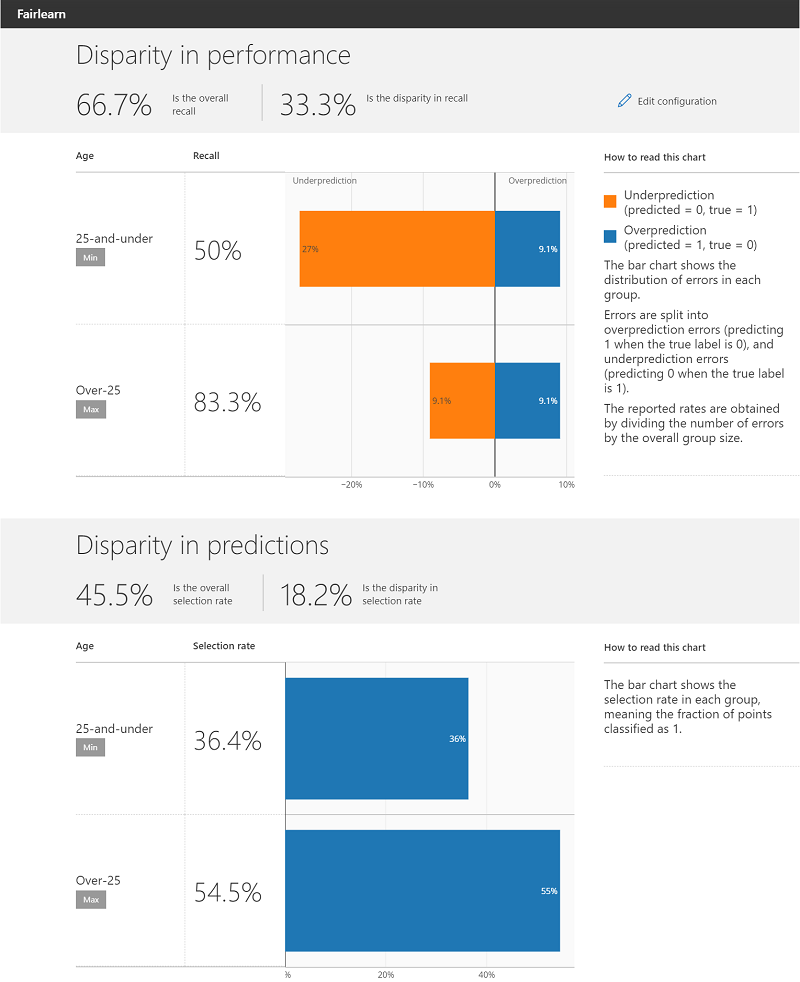

##### Integration with Azure Machine Learning

Fairlearn integrates with Azure Machine Learning by enabling you to run an experiment in which the dashboard metrics are uploaded to your Azure Machine Learning workspace. This enables you to share the dashboard in Azure Machine Learning studio so that your data science team can track and compare disparity metrics for models registered in the workspace.


##### Mitigate unfairness with Fairlearn

In addition to enabling you to analyze disparity in selection rates and predictive performance across sensitive features, Fairlearn provides support for mitigating unfairness in models.
Mitigation algorithms and parity constraints

The mitigation support in Fairlearn is based on the use of algorithms to create alternative models that apply parity constraints to produce comparable metrics across sensitive feature groups. Fairlearn supports the following mitigation techniques.
Mitigation algorithms and parity constraints
Technique 	Description 	Model type support
Exponentiated Gradient 	A reduction technique that applies a cost-minimization approach to learning the optimal trade-off of overall predictive performance and fairness disparity 	Binary classification and regression
Grid Search 	A simplified version of the Exponentiated Gradient algorithm that works efficiently with small numbers of constraints 	Binary classification and regression
Threshold Optimizer 	A post-processing technique that applies a constraint to an existing classifier, transforming the prediction as appropriate 	Binary classification

The choice of parity constraint depends on the technique being used and the specific fairness criteria you want to apply. Constraints in Fairlearn include:

    Demographic parity: Use this constraint with any of the mitigation algorithms to minimize disparity in the selection rate across sensitive feature groups. For example, in a binary classification scenario, this constraint tries to ensure that an equal number of positive predictions are made in each group.
    True positive rate parity: Use this constraint with any of the mitigation algorithms to minimize disparity in true positive rate across sensitive feature groups. For example, in a binary classification scenario, this constraint tries to ensure that each group contains a comparable ratio of true positive predictions.
    False-positive rate parity: Use this constraint with any of the mitigation algorithms to minimize disparity in false_positive_rate across sensitive feature groups. For example, in a binary classification scenario, this constraint tries to ensure that each group contains a comparable ratio of false-positive predictions.
    Equalized odds: Use this constraint with any of the mitigation algorithms to minimize disparity in combined true positive rate and false_positive_rate across sensitive feature groups. For example, in a binary classification scenario, this constraint tries to ensure that each group contains a comparable ratio of true positive and false-positive predictions.
    Error rate parity: Use this constraint with any of the reduction-based mitigation algorithms (Exponentiated Gradient and Grid Search) to ensure that the error for each sensitive feature group does not deviate from the overall error rate by more than a specified amount.
    Bounded group loss: Use this constraint with any of the reduction-based mitigation algorithms to restrict the loss for each sensitive feature group in a regression model.

##### Training and evaluating mitigated models

A common approach to mitigation is to use one of the algorithms and constraints to train multiple models, and then compare their performance, selection rate, and disparity metrics to find the optimal model for your needs. Often, the choice of the model involves a trade-off between raw predictive performance and fairness - based on your definition of fairness for a given scenario. Generally, fairness is measured by a reduction in the disparity of feature selection (for example, ensuring that an equal proportion of members from each gender group is approved for a bank loan) or by a reduction in the disparity of performance metric (for example, ensuring that a model is equally accurate at identifying repayers and defaulters in each age group).

Fairlearn enables you to train mitigated models and visualize them using the dashboard, like this.

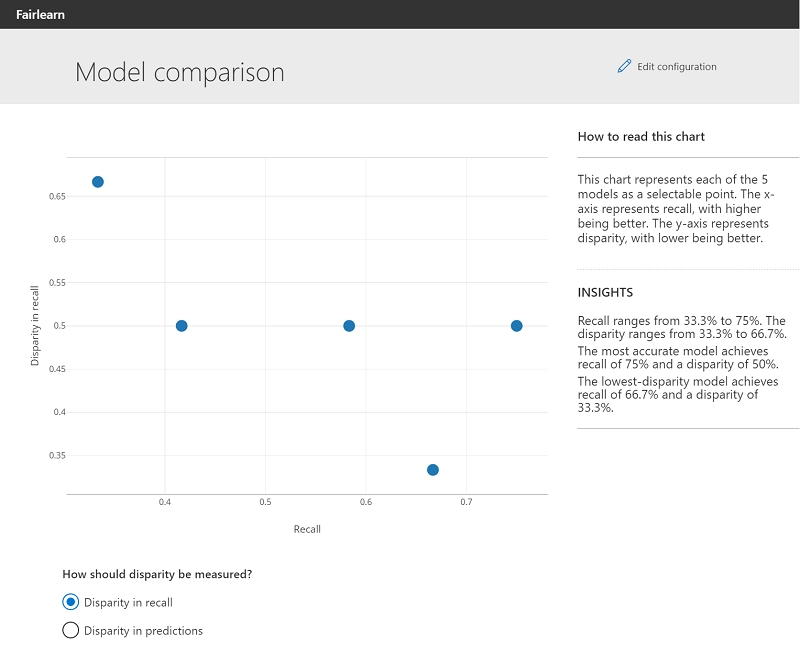

You can select an individual model in the scatterplot to see its details, enabling you to explore the options and select the best model for your fairness requirements.